## Kickstarter-Exploration and -Cleaning


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

ks = pd.read_csv('ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

In [2]:
ks_by_category = ks.groupby(["main_category"], as_index=False)["backers"].sum()
ks_by_category = ks_by_category.sort_values("backers", ascending=True).reset_index(drop=True)
ks_by_category = ks_by_category.tail(10)
ks_by_category

,main_category,backers
5,Art,1188200
6,Food,1332751
7,Fashion,1401993
8,Comics,1458090
9,Publishing,2231589
10,Music,2708475
11,Film & Video,4197577
12,Technology,5356513
13,Design,7255880
14,Games,11336829


[Text(0, 0.5, 'Main Categories'), Text(0.5, 0, 'Backers (in Mio.)')]

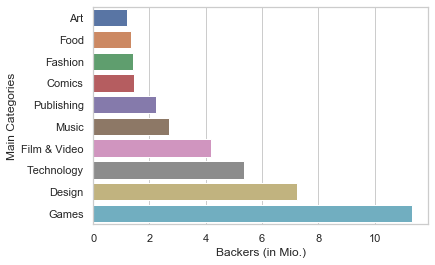

In [3]:
sns.set(style="whitegrid")
bar_plot = sns.barplot(x=ks_by_category.backers/1e6, y=ks_by_category.main_category);
bar_plot.set(xlabel="Backers (in Mio.)", ylabel="Main Categories")

In [4]:
output_graph = bar_plot .get_figure()
output_graph.savefig("srcs/main_categories_by_backers.png", bbox_inches = 'tight')

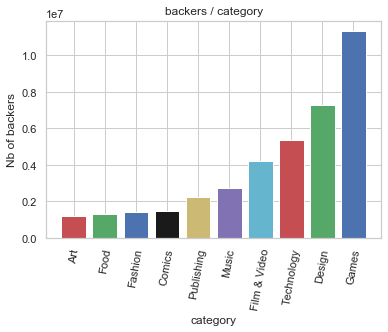

In [5]:
my_colors = 'rgbkymc'

plt.bar(ks_by_category.main_category, ks_by_category.backers, color=my_colors)
plt.xlabel('category')
plt.xticks(rotation=80)
plt.ylabel('Nb of backers')
plt.title('backers / category')

plt.style.use("seaborn")

plt.show()

In [6]:
ks.state.unique()
ks_state_proportion = ks.groupby("state")["ID"].count() / ks["ID"].count()
ks_state_proportion
ks_state_proportion.to_csv('sub_dataframes/ks_state_prportion.csv')


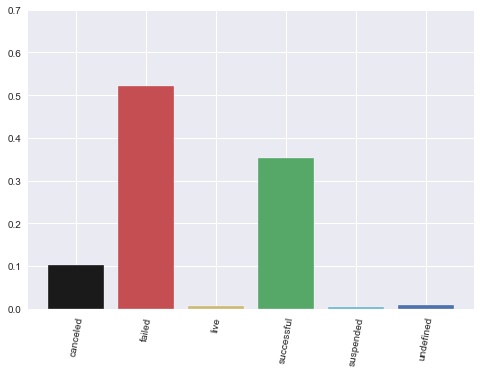

In [7]:
my_colors = 'krygcb' 

plt.bar(ks_state_proportion.index, ks_state_proportion, color=my_colors)

yticks = [0.1*x for x in range(8)]
plt.yticks(yticks)
plt.xticks(rotation=80)
plt.style.use("seaborn")
plt.show()

In [8]:
# Drop live projects
ks = ks.query('state != "live"')

In [9]:
ks.state.unique()

array(['failed', 'canceled', 'successful', 'undefined', 'suspended'],
      dtype=object)

In [10]:
# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

In [11]:
# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

In [19]:
duration = ks[['state']].assign(campaign_duration = ks["deadline"] - ks["launched"])
duration.to_csv('sub_dataframes/campaign_duration.csv')

,state,campaign_duration
0,failed,58 days 11:47:32
1,failed,59 days 19:16:03
2,failed,44 days 23:39:10
3,failed,29 days 20:35:49
4,canceled,55 days 15:24:57
...,...,...
378656,canceled,29 days 21:24:30
378657,failed,26 days 20:24:46
378658,failed,45 days 04:19:30
378659,failed,30 days 05:46:07


In [62]:


# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

baseline_data

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22
...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22
378657,1500.0,3,22,6,2011,0,93,13,22
378658,15000.0,19,1,7,2010,0,93,13,22
378659,15000.0,18,13,1,2016,0,138,13,22


In [63]:
# Defining  functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model...")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [64]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model...
Validation AUC score: 0.7467


### #1 Count Encoding
- add 3 columns with a count
-  Rare values tend to have similar counts (with values like 1 or 2), so you can classify rare values together at prediction time. Common values with large counts are unlikely to have the same exact count as other values. So, the common/important values get their own grouping.
- slight increase but not enough

In [65]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix("_count"))
data

,goal,hour,day,month,year,outcome,category,currency,country,category_count,currency_count,country_count
0,1000.0,12,11,8,2015,0,108,5,9,1362,33853,33393
1,30000.0,4,2,9,2017,0,93,13,22,5174,293624,290887
2,45000.0,0,12,1,2013,0,93,13,22,5174,293624,290887
3,5000.0,3,17,3,2012,0,90,13,22,15647,293624,290887
4,19500.0,8,4,7,2015,0,55,13,22,10054,293624,290887
...,...,...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,16082,293624,290887
378657,1500.0,3,22,6,2011,0,93,13,22,5174,293624,290887
378658,15000.0,19,1,7,2010,0,93,13,22,5174,293624,290887
378659,15000.0,18,13,1,2016,0,138,13,22,6850,293624,290887


In [66]:
# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model...
Validation AUC score: 0.7486


In [67]:
data

,goal,hour,day,month,year,outcome,category,currency,country,category_count,currency_count,country_count
0,1000.0,12,11,8,2015,0,108,5,9,1362,33853,33393
1,30000.0,4,2,9,2017,0,93,13,22,5174,293624,290887
2,45000.0,0,12,1,2013,0,93,13,22,5174,293624,290887
3,5000.0,3,17,3,2012,0,90,13,22,15647,293624,290887
4,19500.0,8,4,7,2015,0,55,13,22,10054,293624,290887
...,...,...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,16082,293624,290887
378657,1500.0,3,22,6,2011,0,93,13,22,5174,293624,290887
378658,15000.0,19,1,7,2010,0,93,13,22,5174,293624,290887
378659,15000.0,18,13,1,2016,0,138,13,22,6850,293624,290887


### #2Target Encoding

In [71]:
# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)
target_encoded = target_enc.fit_transform(data[cat_features], data['outcome']).add_suffix("_target")
target_encoded

data = data.join(target_encoded)
data

,goal,hour,day,month,year,outcome,category,currency,country,category_count,currency_count,country_count,category_target,currency_target,country_target
0,1000.0,12,11,8,2015,0,108,5,9,1362,33853,33393,0.357562,0.356866,0.361363
1,30000.0,4,2,9,2017,0,93,13,22,5174,293624,290887,0.389061,0.372514,0.375744
2,45000.0,0,12,1,2013,0,93,13,22,5174,293624,290887,0.389061,0.372514,0.375744
3,5000.0,3,17,3,2012,0,90,13,22,15647,293624,290887,0.411069,0.372514,0.375744
4,19500.0,8,4,7,2015,0,55,13,22,10054,293624,290887,0.305351,0.372514,0.375744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,16082,293624,290887,0.368362,0.372514,0.375744
378657,1500.0,3,22,6,2011,0,93,13,22,5174,293624,290887,0.389061,0.372514,0.375744
378658,15000.0,19,1,7,2010,0,93,13,22,5174,293624,290887,0.389061,0.372514,0.375744
378659,15000.0,18,13,1,2016,0,138,13,22,6850,293624,290887,0.192263,0.372514,0.375744


In [73]:
train, valid, _ = get_data_splits(data)
train.head()
bst = train_model(train, valid)

Training model...
Validation AUC score: 0.7495


### #3CatBoost Encoding
- similar to target encoding in that it's based on the target probablity for a given value. However with CatBoost, for each row, the target probability is calculated only from the rows before i

In [76]:
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_encoder2 = target_enc.fit_transform(data[cat_features], data["outcome"]).add_suffix("_catboost")
target_encoder2

data = data.join(target_encoder2)
data


,goal,hour,day,month,year,outcome,category,currency,country,category_count,...,country_count,category_target,currency_target,country_target,category_last,currency_last,country_last,category_catboost,currency_catboost,country_catboost
0,1000.0,12,11,8,2015,0,108,5,9,1362,...,33393,0.357562,0.356866,0.361363,0.356397,0.356397,0.356397,0.356397,0.356397,0.356397
1,30000.0,4,2,9,2017,0,93,13,22,5174,...,290887,0.389061,0.372514,0.375744,0.356397,0.356397,0.356397,0.356397,0.356397,0.356397
2,45000.0,0,12,1,2013,0,93,13,22,5174,...,290887,0.389061,0.372514,0.375744,0.178198,0.178198,0.178198,0.178198,0.178198,0.178198
3,5000.0,3,17,3,2012,0,90,13,22,15647,...,290887,0.411069,0.372514,0.375744,0.356397,0.118799,0.118799,0.356397,0.118799,0.118799
4,19500.0,8,4,7,2015,0,55,13,22,10054,...,290887,0.305351,0.372514,0.375744,0.356397,0.089099,0.089099,0.356397,0.089099,0.089099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,16082,...,290887,0.368362,0.372514,0.375744,0.368384,0.372520,0.375750,0.368384,0.372520,0.375750
378657,1500.0,3,22,6,2011,0,93,13,22,5174,...,290887,0.389061,0.372514,0.375744,0.389205,0.372519,0.375749,0.389205,0.372519,0.375749
378658,15000.0,19,1,7,2010,0,93,13,22,5174,...,290887,0.389061,0.372514,0.375744,0.389130,0.372518,0.375748,0.389130,0.372518,0.375748
378659,15000.0,18,13,1,2016,0,138,13,22,6850,...,290887,0.192263,0.372514,0.375744,0.192315,0.372516,0.375746,0.192315,0.372516,0.375746


In [78]:
train, valid, test = get_data_splits(data)
train.head()
train_model(train, valid)

Training model...
Validation AUC score: 0.7494
